In [1]:
library(tidyverse)
library(broom)

── Attaching core tidyverse packages ──────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
set.seed(123)
n <- 2000

dados <- tibble(
  Disease = sample(c("Chikungunya", "Dengue"), n, replace = TRUE),
  Sex = sample(c("Male", "Female"), n, replace = TRUE),
  Age = sample(1:100, n, replace = TRUE),
  Diabetes = rbinom(n, 1, 0.2),
  Autoimmune = rbinom(n, 1, 0.05),
  Hematologic = rbinom(n, 1, 0.03),
  Liver = rbinom(n, 1, 0.04),
  Hypertension = rbinom(n, 1, 0.3),
  Kidney = rbinom(n, 1, 0.05)
)

In [3]:
head(dados)

Disease,Sex,Age,Diabetes,Autoimmune,Hematologic,Liver,Hypertension,Kidney
<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
Chikungunya,Male,52,0,0,0,0,1,0
Chikungunya,Male,37,0,0,0,0,0,0
Chikungunya,Male,71,1,0,0,0,1,0
Dengue,Female,31,0,0,0,0,1,0
Chikungunya,Female,31,0,0,0,0,0,0
Dengue,Male,50,1,1,0,0,1,0


In [4]:
dados <- dados %>%
  mutate(
    AgeGroup = cut(
      Age,
      breaks = c(0, 1, 9, 19, 39, 49, 59, 69, 79, 89, Inf),
      labels = c("<1", "1-9", "10-19", "20-39", "40-49", "50-59",
                 "60-69", "70-79", "80-89", "≥90"),
      right = FALSE
    ),
    Outcome = rbinom(n, 1, prob = plogis(
      -2 +
        0.3 * (Sex == "Male") +
        0.5 * (AgeGroup %in% c("70-79", "80-89", "≥90")) +
        0.6 * Diabetes +
        0.8 * Autoimmune +
        1.2 * Hematologic +
        0.7 * Liver +
        0.4 * Hypertension +
        1.1 * Kidney
    ))
  )
head(dados)

Disease,Sex,Age,Diabetes,Autoimmune,Hematologic,Liver,Hypertension,Kidney,AgeGroup,Outcome
<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<int>
Chikungunya,Male,52,0,0,0,0,1,0,50-59,0
Chikungunya,Male,37,0,0,0,0,0,0,20-39,0
Chikungunya,Male,71,1,0,0,0,1,0,70-79,0
Dengue,Female,31,0,0,0,0,1,0,20-39,0
Chikungunya,Female,31,0,0,0,0,0,0,20-39,0
Dengue,Male,50,1,1,0,0,1,0,50-59,0


In [5]:
model <- function(x) {
  glm(
    Outcome ~ Sex + AgeGroup + Diabetes + Autoimmune + Hematologic +
      Liver + Hypertension + Kidney,
    data = filter(dados, Disease == x),
    family = binomial
  )
}

In [6]:
model_chik <- model("Chikungunya")
model_chik


Call:  glm(formula = Outcome ~ Sex + AgeGroup + Diabetes + Autoimmune + 
    Hematologic + Liver + Hypertension + Kidney, family = binomial, 
    data = filter(dados, Disease == x))

Coefficients:
  (Intercept)        SexMale  AgeGroup10-19  AgeGroup20-39  AgeGroup40-49  
     -2.20943        0.43135       -0.29625       -0.43789       -0.07921  
AgeGroup50-59  AgeGroup60-69  AgeGroup70-79  AgeGroup80-89    AgeGroup≥90  
     -0.41942       -0.32301        0.50355        0.94622        0.59512  
     Diabetes     Autoimmune    Hematologic          Liver   Hypertension  
      0.81485        0.90137        1.39289        1.26796        0.32296  
       Kidney  
      1.48438  

Degrees of Freedom: 1020 Total (i.e. Null);  1005 Residual
Null Deviance:	    1038 
Residual Deviance: 929 	AIC: 961

In [7]:
model_dengue <- model("Dengue")
model_dengue


Call:  glm(formula = Outcome ~ Sex + AgeGroup + Diabetes + Autoimmune + 
    Hematologic + Liver + Hypertension + Kidney, family = binomial, 
    data = filter(dados, Disease == x))

Coefficients:
  (Intercept)        SexMale  AgeGroup10-19  AgeGroup20-39  AgeGroup40-49  
      -1.3578         0.2100        -0.3745        -1.0984        -0.7468  
AgeGroup50-59  AgeGroup60-69  AgeGroup70-79  AgeGroup80-89    AgeGroup≥90  
      -1.1404        -0.9910        -0.5163        -0.2260        -0.4879  
     Diabetes     Autoimmune    Hematologic          Liver   Hypertension  
       0.7833         0.5646         2.2991         0.9179         0.6676  
       Kidney  
       1.1713  

Degrees of Freedom: 978 Total (i.e. Null);  963 Residual
Null Deviance:	    1036 
Residual Deviance: 939.1 	AIC: 971.1

In [8]:
extract_OR <- function(model, x) {
  tidy(model, conf.int = TRUE, exponentiate = TRUE) %>%
    filter(term != "(Intercept)") %>%
    mutate(Disease = x)
}

In [9]:
res_chik <- extract_OR(model_chik, "Chikungunya")
res_dengue <- extract_OR(model_dengue, "Dengue")

In [10]:
head(res_chik)

term,estimate,std.error,statistic,p.value,conf.low,conf.high,Disease
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
SexMale,1.5393326,0.1673221,2.5779557,0.009938675,1.1107598,2.141898,Chikungunya
AgeGroup10-19,0.7436009,0.3983466,-0.7437011,0.457057305,0.3377679,1.624260,Chikungunya
AgeGroup20-39,0.6453977,0.3507890,-1.2482964,0.211922540,0.3262532,1.298970,Chikungunya
AgeGroup40-49,0.9238464,0.3868832,-0.2047374,0.837777309,0.4311526,1.980467,Chikungunya
AgeGroup50-59,0.6574309,0.4006488,-1.0468412,0.295172821,0.2964296,1.439702,Chikungunya
AgeGroup60-69,0.7239670,0.3993312,-0.8088763,0.418586323,0.3281667,1.584068,Chikungunya


In [11]:
head(res_dengue)

term,estimate,std.error,statistic,p.value,conf.low,conf.high,Disease
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
SexMale,1.2336213,0.1649536,1.272807,0.2030865735,0.8932216,1.7063802,Dengue
AgeGroup10-19,0.6876136,0.3461602,-1.081950,0.2792745743,0.3478951,1.3570717,Dengue
AgeGroup20-39,0.3334139,0.3254082,-3.375363,0.0007371846,0.1759164,0.6325167,Dengue
AgeGroup40-49,0.4738838,0.3651469,-2.045186,0.0408365452,0.2296008,0.9658233,Dengue
AgeGroup50-59,0.3196814,0.3932148,-2.900273,0.0037283801,0.1450240,0.6824892,Dengue
AgeGroup60-69,0.3712017,0.3656514,-2.710259,0.0067230728,0.1792948,0.7560217,Dengue


In [12]:
results <- bind_rows(res_chik, res_dengue) %>%
  mutate(
    term = gsub("Sex", "Sex: ", term),
    term = gsub("AgeGroup", "Age Group: ", term),
    term = gsub("Diabetes", "Diabetes", term),
    term = gsub("Autoimmune", "Autoimmune disease", term),
    term = gsub("Hematologic", "Hematological disease", term),
    term = gsub("Liver", "Liver disease", term),
    term = gsub("Hypertension", "Hypertension", term),
    term = gsub("Kidney", "Kidney disease", term),
    term = gsub("\\)", "", gsub("\\(", "", term)),
    term = gsub("\\: ", ": ", term)
  ) %>%
  rename(OR = estimate, CI_low = conf.low, CI_high = conf.high)
head(results, 20)

term,OR,std.error,statistic,p.value,CI_low,CI_high,Disease
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Sex: Male,1.5393326,0.1673221,2.5779557,9.938675e-03,1.1107598,2.1418981,Chikungunya
Age Group: 10-19,0.7436009,0.3983466,-0.7437011,4.570573e-01,0.3377679,1.6242604,Chikungunya
Age Group: 20-39,0.6453977,0.3507890,-1.2482964,2.119225e-01,0.3262532,1.2989704,Chikungunya
Age Group: 40-49,0.9238464,0.3868832,-0.2047374,8.377773e-01,0.4311526,1.9804666,Chikungunya
Age Group: 50-59,0.6574309,0.4006488,-1.0468412,2.951728e-01,0.2964296,1.4397021,Chikungunya
Age Group: 60-69,0.7239670,0.3993312,-0.8088763,4.185863e-01,0.3281667,1.5840675,Chikungunya
Age Group: 70-79,1.6545884,0.3640407,1.3832305,1.665942e-01,0.8159275,3.4197230,Chikungunya
Age Group: 80-89,2.5759452,0.3507802,2.6974628,6.987010e-03,1.3102202,5.2089115,Chikungunya
Age Group: ≥90,1.8132552,0.3511145,1.6949561,9.008376e-02,0.9200792,3.6642114,Chikungunya


In [13]:
results_sep <- results %>%
  mutate(
    Variable = case_when(
      grepl("Age Group", term) ~ "Age Group",
      grepl("Sex", term) ~ "Sex",
      TRUE ~ "Comorbidity"
    ),
    Level = case_when(
      grepl("Age Group: ", term) ~ gsub("Age Group: ", "", term),
      grepl("Sex: ", term) ~ gsub("Sex: ", "", term),
      TRUE ~ term
    )
  )
head(results_sep)

term,OR,std.error,statistic,p.value,CI_low,CI_high,Disease,Variable,Level
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
Sex: Male,1.5393326,0.1673221,2.5779557,0.009938675,1.1107598,2.141898,Chikungunya,Sex,Male
Age Group: 10-19,0.7436009,0.3983466,-0.7437011,0.457057305,0.3377679,1.624260,Chikungunya,Age Group,10-19
Age Group: 20-39,0.6453977,0.3507890,-1.2482964,0.211922540,0.3262532,1.298970,Chikungunya,Age Group,20-39
Age Group: 40-49,0.9238464,0.3868832,-0.2047374,0.837777309,0.4311526,1.980467,Chikungunya,Age Group,40-49
Age Group: 50-59,0.6574309,0.4006488,-1.0468412,0.295172821,0.2964296,1.439702,Chikungunya,Age Group,50-59
Age Group: 60-69,0.7239670,0.3993312,-0.8088763,0.418586323,0.3281667,1.584068,Chikungunya,Age Group,60-69


In [14]:
order_vars <- results_sep %>%
  group_by(Variable, Level) %>%
  summarise() %>%
  arrange(
    match(Variable, c("Age Group", "Comorbidity", "Sex")),
    desc(Level)
  ) %>%
  mutate(
    label = ifelse(duplicated(Variable), paste0("   ", Level), Variable)
  )
head(order_vars)

`summarise()` has grouped output by 'Variable'. You can override using the `.groups` argument.


Variable,Level,label
<chr>,<chr>,<chr>
Age Group,≥90,Age Group
Age Group,80-89,80-89
Age Group,70-79,70-79
Age Group,60-69,60-69
Age Group,50-59,50-59
Age Group,40-49,40-49


In [15]:
results_sep <- results_sep %>%
  left_join(order_vars, by = c("Variable", "Level"))
results_sep

term,OR,std.error,statistic,p.value,CI_low,CI_high,Disease,Variable,Level,label
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
Sex: Male,1.5393326,0.1673221,2.5779557,9.938675e-03,1.1107598,2.1418981,Chikungunya,Sex,Male,Sex
Age Group: 10-19,0.7436009,0.3983466,-0.7437011,4.570573e-01,0.3377679,1.6242604,Chikungunya,Age Group,10-19,10-19
Age Group: 20-39,0.6453977,0.3507890,-1.2482964,2.119225e-01,0.3262532,1.2989704,Chikungunya,Age Group,20-39,20-39
Age Group: 40-49,0.9238464,0.3868832,-0.2047374,8.377773e-01,0.4311526,1.9804666,Chikungunya,Age Group,40-49,40-49
Age Group: 50-59,0.6574309,0.4006488,-1.0468412,2.951728e-01,0.2964296,1.4397021,Chikungunya,Age Group,50-59,50-59
Age Group: 60-69,0.7239670,0.3993312,-0.8088763,4.185863e-01,0.3281667,1.5840675,Chikungunya,Age Group,60-69,60-69
Age Group: 70-79,1.6545884,0.3640407,1.3832305,1.665942e-01,0.8159275,3.4197230,Chikungunya,Age Group,70-79,70-79
Age Group: 80-89,2.5759452,0.3507802,2.6974628,6.987010e-03,1.3102202,5.2089115,Chikungunya,Age Group,80-89,80-89
Age Group: ≥90,1.8132552,0.3511145,1.6949561,9.008376e-02,0.9200792,3.6642114,Chikungunya,Age Group,≥90,Age Group


Warning message:
“Removed 3 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 13 rows containing missing values (`geom_errorbarh()`).”


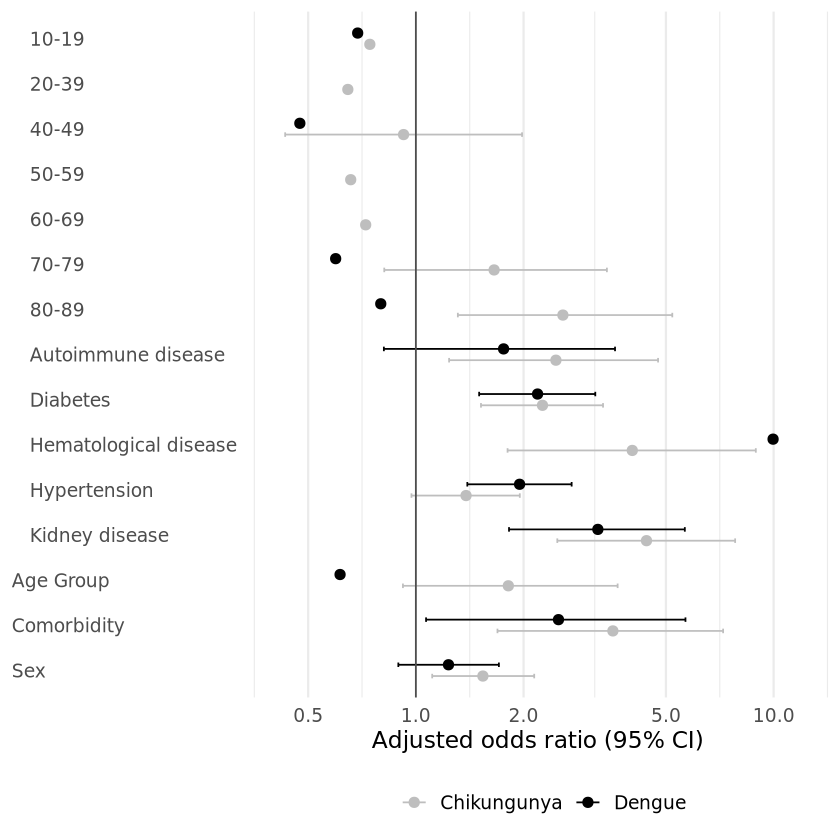

In [16]:
ggplot(results_sep, aes(x = OR, y = fct_rev(label), color = Disease)) +
  geom_point(position = position_dodge(width = 0.5), size = 2.5) +
  geom_errorbarh(aes(xmin = CI_low, xmax = CI_high),
                 position = position_dodge(width = 0.5),
                 height = 0.2) +
  geom_vline(xintercept = 1, linetype = "solid", color = "gray30") +
  scale_x_log10(breaks = c(0.5, 1, 2, 5, 10), limits = c(0.4, 12)) +
  scale_color_manual(values = c("Chikungunya" = "gray", "Dengue" = "black")) +
  labs(
    x = "Adjusted odds ratio (95% CI)",
    y = NULL,
    color = NULL
  ) +
  theme_minimal(base_size = 14) +
  theme(
    axis.text.y = element_text(hjust = 0),
    panel.grid.major.y = element_blank(),
    legend.position = "bottom"
  )

In [21]:
order_vars <- order_vars %>%
    mutate(y_pos = row_number())
head(order_vars)

Variable,Level,label,y_pos
<chr>,<chr>,<chr>,<int>
Age Group,≥90,Age Group,1
Age Group,80-89,80-89,2
Age Group,70-79,70-79,3
Age Group,60-69,60-69,4
Age Group,50-59,50-59,5
Age Group,40-49,40-49,6


In [22]:
results_sep <- results_sep %>%
    left_join(order_vars, by = c("Variable", "Level"))
head(results_sep)

term,OR,std.error,statistic,p.value,CI_low,CI_high,Disease,Variable,Level,label.x,label.y,y_pos.x,label,y_pos.y
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>
Sex: Male,1.5393326,0.1673221,2.5779557,0.009938675,1.1107598,2.141898,Chikungunya,Sex,Male,Sex,Sex,1,Sex,1
Age Group: 10-19,0.7436009,0.3983466,-0.7437011,0.457057305,0.3377679,1.624260,Chikungunya,Age Group,10-19,10-19,10-19,8,10-19,8
Age Group: 20-39,0.6453977,0.3507890,-1.2482964,0.211922540,0.3262532,1.298970,Chikungunya,Age Group,20-39,20-39,20-39,7,20-39,7
Age Group: 40-49,0.9238464,0.3868832,-0.2047374,0.837777309,0.4311526,1.980467,Chikungunya,Age Group,40-49,40-49,40-49,6,40-49,6
Age Group: 50-59,0.6574309,0.4006488,-1.0468412,0.295172821,0.2964296,1.439702,Chikungunya,Age Group,50-59,50-59,50-59,5,50-59,5
Age Group: 60-69,0.7239670,0.3993312,-0.8088763,0.418586323,0.3281667,1.584068,Chikungunya,Age Group,60-69,60-69,60-69,4,60-69,4


In [26]:
seps <- results_sep %>%
  distinct(Variable, y_pos.y) %>%
  group_by(Variable) %>%
  summarise(max_y = max(y_pos.y)) %>%
  arrange(match(Variable, c("Age Group", "Comorbidity", "Sex"))) %>%
  mutate(y_sep = lag(max_y) + 0.5) %>%
  filter(!is.na(y_sep))
seps

Variable,max_y,y_sep
<chr>,<int>,<dbl>
Comorbidity,6,8.5
Sex,1,6.5


Warning message:
“Removed 3 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 13 rows containing missing values (`geom_errorbarh()`).”


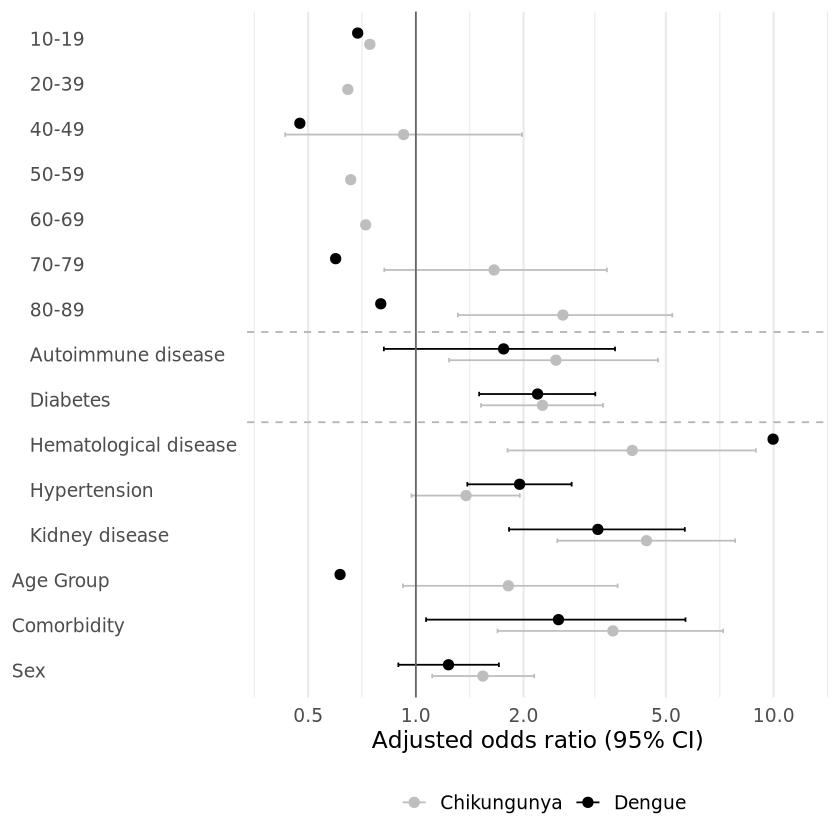

In [30]:
ggplot(results_sep, aes(x = OR, y = fct_rev(label), color = Disease)) +
  geom_point(position = position_dodge(width = 0.5), size = 2.5) +
  geom_errorbarh(aes(xmin = CI_low, xmax = CI_high),
                 position = position_dodge(width = 0.5),
                 height = 0.2) +
  geom_vline(xintercept = 1, linetype = "solid", color = "gray40") +
  geom_hline(data = seps, aes(yintercept = y_sep), linetype = "dashed", color = "gray70") +
  scale_x_log10(breaks = c(0.5, 1, 2, 5, 10), limits = c(0.4, 12)) +
  scale_color_manual(values = c("Chikungunya" = "gray", "Dengue" = "black")) +
  labs(
    x = "Adjusted odds ratio (95% CI)",
    y = NULL,
    color = NULL
  ) +
  theme_minimal(base_size = 14) +
  theme(
    axis.text.y = element_text(hjust = 0),
    panel.grid.major.y = element_blank(),
    legend.position = "bottom"
  )

In [32]:
results_sep <- results %>%
  mutate(
    Variable = case_when(
      grepl("Age Group", term) ~ "Age Group",
      grepl("Sex", term) ~ "Sex",
      TRUE ~ "Comorbidity"
    ),
    Level = case_when(
      grepl("Age Group: ", term) ~ gsub("Age Group: ", "", term),
      grepl("Sex: ", term) ~ gsub("Sex: ", "", term),
      TRUE ~ term
    )
  )

In [43]:
results_sep <- results_sep %>%
  group_by(Variable) %>%
  mutate(Level = fct_rev(fct_inorder(Level))) %>%
  ungroup()

In [42]:
results_sep

term,OR,std.error,statistic,p.value,CI_low,CI_high,Disease,Variable,Level
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>
Sex: Male,1.5393326,0.1673221,2.5779557,9.938675e-03,1.1107598,2.1418981,Chikungunya,Sex,Male
Age Group: 10-19,0.7436009,0.3983466,-0.7437011,4.570573e-01,0.3377679,1.6242604,Chikungunya,Age Group,10-19
Age Group: 20-39,0.6453977,0.3507890,-1.2482964,2.119225e-01,0.3262532,1.2989704,Chikungunya,Age Group,20-39
Age Group: 40-49,0.9238464,0.3868832,-0.2047374,8.377773e-01,0.4311526,1.9804666,Chikungunya,Age Group,40-49
Age Group: 50-59,0.6574309,0.4006488,-1.0468412,2.951728e-01,0.2964296,1.4397021,Chikungunya,Age Group,50-59
Age Group: 60-69,0.7239670,0.3993312,-0.8088763,4.185863e-01,0.3281667,1.5840675,Chikungunya,Age Group,60-69
Age Group: 70-79,1.6545884,0.3640407,1.3832305,1.665942e-01,0.8159275,3.4197230,Chikungunya,Age Group,70-79
Age Group: 80-89,2.5759452,0.3507802,2.6974628,6.987010e-03,1.3102202,5.2089115,Chikungunya,Age Group,80-89
Age Group: ≥90,1.8132552,0.3511145,1.6949561,9.008376e-02,0.9200792,3.6642114,Chikungunya,Age Group,≥90


In [39]:
str(results_sep)

tibble [30 × 10] (S3: tbl_df/tbl/data.frame)
 $ term     : chr [1:30] "Sex: Male" "Age Group: 10-19" "Age Group: 20-39" "Age Group: 40-49" ...
 $ OR       : num [1:30] 1.539 0.744 0.645 0.924 0.657 ...
 $ std.error: num [1:30] 0.167 0.398 0.351 0.387 0.401 ...
 $ statistic: num [1:30] 2.578 -0.744 -1.248 -0.205 -1.047 ...
 $ p.value  : num [1:30] 0.00994 0.45706 0.21192 0.83778 0.29517 ...
 $ CI_low   : num [1:30] 1.111 0.338 0.326 0.431 0.296 ...
 $ CI_high  : num [1:30] 2.14 1.62 1.3 1.98 1.44 ...
 $ Disease  : chr [1:30] "Chikungunya" "Chikungunya" "Chikungunya" "Chikungunya" ...
 $ Variable : chr [1:30] "Sex" "Age Group" "Age Group" "Age Group" ...
 $ Level    : Factor w/ 15 levels "Male","Diabetes",..: 1 15 14 13 12 11 10 9 8 2 ...


In [40]:
summary(results_sep)

     term                 OR           std.error        statistic     
 Length:30          Min.   :0.3197   Min.   :0.1650   Min.   :-3.375  
 Class :character   1st Qu.:0.6650   1st Qu.:0.2996   1st Qu.:-1.073  
 Mode  :character   Median :1.4603   Median :0.3515   Median : 1.442  
                    Mean   :1.8797   Mean   :0.3276   Mean   : 1.056  
                    3rd Qu.:2.4119   3rd Qu.:0.3843   3rd Qu.: 3.257  
                    Max.   :9.9648   Max.   :0.4217   Max.   : 5.453  
                                                                      
    p.value              CI_low          CI_high          Disease         
 Min.   :0.0000000   Min.   :0.1450   Min.   : 0.6325   Length:30         
 1st Qu.:0.0006154   1st Qu.:0.3267   1st Qu.: 1.3777   Class :character  
 Median :0.0351756   Median :0.8546   Median : 2.0612   Mode  :character  
 Mean   :0.1362812   Mean   :0.9869   Mean   : 3.6945                     
 3rd Qu.:0.1939635   3rd Qu.:1.3720   3rd Qu.: 4.4810    

Warning message:
“Removed 3 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 13 rows containing missing values (`geom_errorbarh()`).”


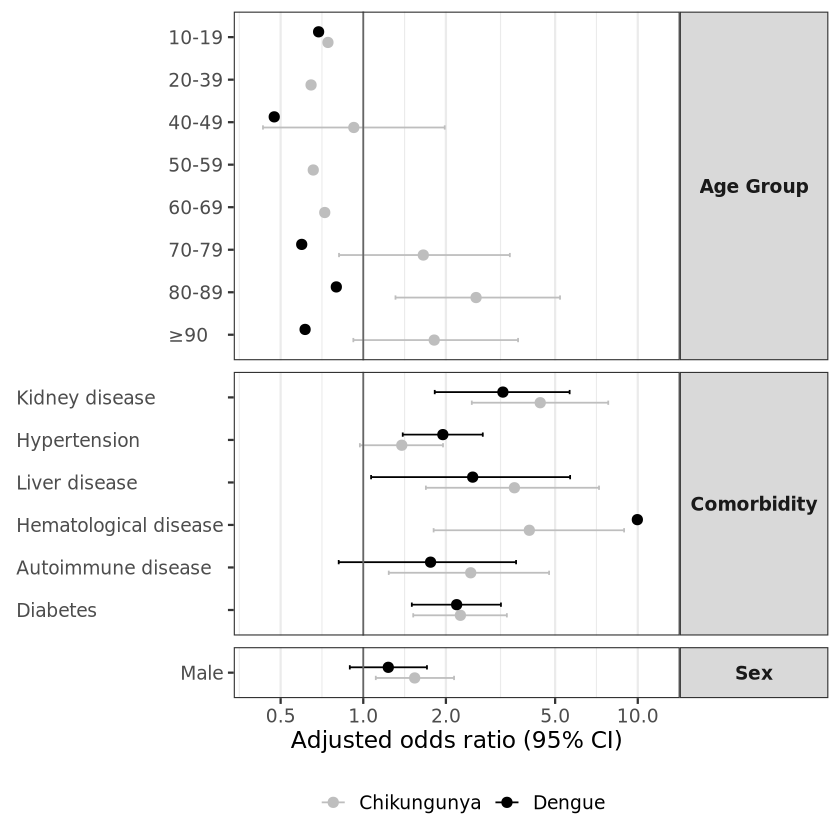

In [41]:
ggplot(results_sep, aes(x = OR, y = Level, color = Disease)) +
  geom_point(position = position_dodge(width = 0.5), size = 2.5) +
  geom_errorbarh(aes(xmin = CI_low, xmax = CI_high),
                 position = position_dodge(width = 0.5),
                 height = 0.2) +
  geom_vline(xintercept = 1, linetype = "solid", color = "gray40") +
  scale_x_log10(breaks = c(0.5, 1, 2, 5, 10), limits = c(0.4, 12)) +
  scale_color_manual(values = c("Chikungunya" = "gray", "Dengue" = "black")) +
  facet_grid(rows = vars(Variable), scales = "free_y", space = "free_y") +
  labs(
    x = "Adjusted odds ratio (95% CI)",
    y = NULL,
    color = NULL
  ) +
  theme_bw(base_size = 14) +
  theme(
    strip.text.y = element_text(angle = 0, face = "bold"),
    panel.grid.major.y = element_blank(),
    axis.text.y = element_text(hjust = 0),
    legend.position = "bottom"
  )